# Proyecto Big Data – Ingesta TradingView (Stellar / XLM) y particionado en RAW

Este notebook muestra, de forma ordenada y reproducible:

1. Acceso a TradingView (vía librería `TradingviewData`).
2. Prueba rápida de descarga (daily) y verificación en pantalla.
3. Ingesta completa (daily) para 2022–2025.
4. Limpieza: eliminamos `symbol` antes de guardar (evitamos redundancia).
5. Almacenamiento en RAW con dos estrategias:
   - `yearly/` → un CSV por año.
   - `monthly/` → un CSV por mes dentro de cada año.


In [8]:
import os
import pandas as pd
from TradingviewData import TradingViewData, Interval
import matplotlib.pyplot as plt
import pandas as pd

In [9]:
import sys
print(sys.executable)

/opt/anaconda3/bin/python


## 1) Acceso a TradingView (cliente)

Creamos el cliente `TradingViewData()`. La librería gestiona internamente la conexión/consulta a TradingView.


In [10]:
request = TradingViewData()

## 2) Prueba rápida: descarga DAILY y evidencia en pantalla

Descargamos pocas filas (n_bars=10) para demostrar que el acceso funciona y ver el formato de los datos.


In [11]:
sample = request.get_hist(
    symbol="XLMUSD",
    exchange="BINANCE",
    interval=Interval.daily,
    n_bars=100
)

sample

,symbol,open,high,low,close,volume
datetime,,,,,,
2025-10-19 02:00:00,BINANCE:XLMUSD,0.314082,0.323855,0.306967,0.318392,928103.0
2025-10-20 02:00:00,BINANCE:XLMUSD,0.317329,0.332795,0.313467,0.325273,806301.0
2025-10-21 02:00:00,BINANCE:XLMUSD,0.323632,0.332839,0.313586,0.314418,1327289.0
2025-10-22 02:00:00,BINANCE:XLMUSD,0.314257,0.315202,0.301700,0.307840,513510.0
2025-10-23 02:00:00,BINANCE:XLMUSD,0.308829,0.316890,0.308829,0.311460,108897.0
...,...,...,...,...,...,...
2026-01-22 01:00:00,BINANCE:XLMUSD,0.212914,0.216668,0.209693,0.211647,959800.0
2026-01-23 01:00:00,BINANCE:XLMUSD,0.211177,0.218210,0.208352,0.212097,942584.0
2026-01-24 01:00:00,BINANCE:XLMUSD,0.212047,0.212696,0.210330,0.211521,434138.0


## 2.5) Representación gráfica inicial (validación visual)

Antes de continuar con el almacenamiento y particionado, se realiza una
visualización simple del precio de cierre (`close`) para validar
visualmente que los datos descargados son coherentes.


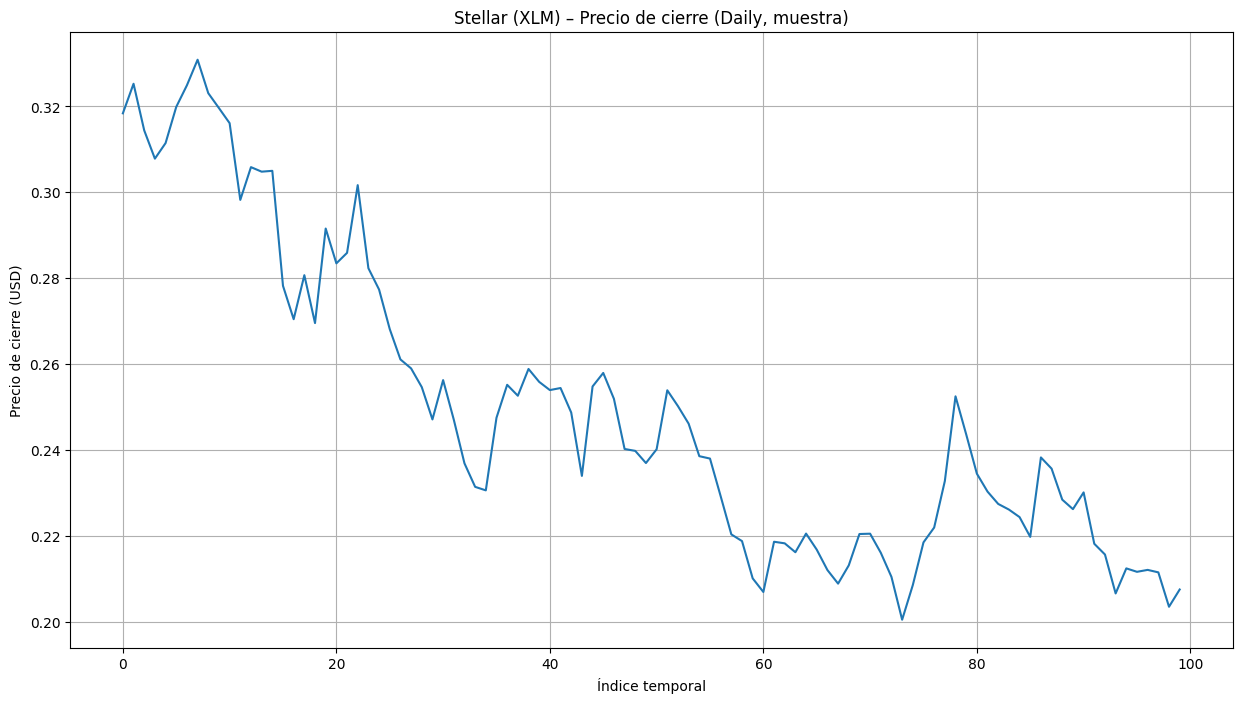

In [12]:
# Normalizar sample
sample_df = sample.reset_index()
sample_df["datetime"] = pd.to_datetime(sample_df["datetime"], utc=True)

# Gráfica del precio de cierre
sample_df["close"].plot(figsize=(15, 8))
plt.title("Stellar (XLM) – Precio de cierre (Daily, muestra)")
plt.xlabel("Índice temporal")
plt.ylabel("Precio de cierre (USD)")
plt.grid(True)
plt.show()

## 3) Ingesta completa DAILY (para llegar a 2022)

Usamos `n_bars` alto para cubrir aproximadamente desde 2022 hasta el presente.
Si el mínimo no llega a 2022, aumentar `n_bars` (por ejemplo 2000).


In [13]:
data = request.get_hist(
    symbol="XLMUSD",          # alternativa: "XLMUSDT"
    exchange="BINANCE",
    interval=Interval.daily,
    n_bars=1800
)

df = data.reset_index()
df["datetime"] = pd.to_datetime(df["datetime"], utc=True)

print("Rango descargado:", df["datetime"].min(), "→", df["datetime"].max())
df.head()


Rango descargado: 2021-02-22 01:00:00+00:00 → 2026-01-26 01:00:00+00:00


,datetime,symbol,open,high,low,close,volume
0,2021-02-22 01:00:00+00:00,BINANCE:XLMUSD,0.496711,0.545277,0.371106,0.464129,1.298780e+08
1,2021-02-23 01:00:00+00:00,BINANCE:XLMUSD,0.463495,0.465576,0.307756,0.386395,1.482691e+08
2,2021-02-24 01:00:00+00:00,BINANCE:XLMUSD,0.386410,0.436724,0.367105,0.404950,7.188297e+07
3,2021-02-25 01:00:00+00:00,BINANCE:XLMUSD,0.404802,0.433853,0.373650,0.380366,5.310403e+07
4,2021-02-26 01:00:00+00:00,BINANCE:XLMUSD,0.380278,0.419712,0.349556,0.400749,6.170771e+07


## 4) Filtrado 2022–2025 y limpieza

- Filtramos los años 2022 a 2025.
- Eliminamos la columna `symbol` antes de guardar:
  - Es redundante (ya sabemos que el dataset es XLM por la ruta/nombre).
  - A escala Big Data, guardar campos redundantes incrementa almacenamiento y coste de procesamiento.


In [14]:
df = df[df["datetime"].dt.year.between(2022, 2025)].copy()

if "symbol" in df.columns:
    df = df.drop(columns=["symbol"])

years_available = sorted(df["datetime"].dt.year.unique())
print("Años disponibles:", years_available)

df.head()


Años disponibles: [2022, 2023, 2024, 2025]


,datetime,open,high,low,close,volume
313,2022-01-01 01:00:00+00:00,0.266864,0.280046,0.263113,0.276927,1.489520e+07
314,2022-01-02 01:00:00+00:00,0.277060,0.297308,0.270683,0.292460,2.047819e+07
315,2022-01-03 01:00:00+00:00,0.292158,0.301638,0.279243,0.289828,2.658327e+07
316,2022-01-04 01:00:00+00:00,0.290102,0.297851,0.275504,0.279617,1.526306e+07
317,2022-01-05 01:00:00+00:00,0.279471,0.299475,0.254579,0.266800,3.522648e+07


## 5) Particionado en RAW (yearly y monthly)

Creamos dos estructuras en `data/raw/stellar/`:

- `yearly/`: un CSV por año (útil para análisis por año completo).
- `monthly/`: un CSV por mes dentro de cada año (útil para procesos incrementales y consultas más selectivas).

Estructura resultante:
- `data/raw/stellar/yearly/year=YYYY.csv`
- `data/raw/stellar/monthly/year=YYYY/month=MM.csv`


In [15]:
base_dir = "data/raw/stellar"
yearly_dir = os.path.join(base_dir, "yearly")
monthly_dir = os.path.join(base_dir, "monthly")

os.makedirs(yearly_dir, exist_ok=True)
os.makedirs(monthly_dir, exist_ok=True)

# 5.1) Yearly
for year in years_available:
    df_year = df[df["datetime"].dt.year == year].copy()
    out_path = os.path.join(yearly_dir, f"year={year}.csv")
    df_year.to_csv(out_path, index=False)
    print(f"yearly -> {out_path} | filas: {len(df_year)}")

# 5.2) Monthly
for year in years_available:
    year_folder = os.path.join(monthly_dir, f"year={year}")
    os.makedirs(year_folder, exist_ok=True)

    months_available = sorted(df[df["datetime"].dt.year == year]["datetime"].dt.month.unique())
    for month in months_available:
        mm = f"{month:02d}"
        df_month = df[(df["datetime"].dt.year == year) & (df["datetime"].dt.month == month)].copy()
        out_path = os.path.join(year_folder, f"month={mm}.csv")
        df_month.to_csv(out_path, index=False)
        print(f"monthly -> {out_path} | filas: {len(df_month)}")

print("Estructura creada en:", os.path.abspath(base_dir))


yearly -> data/raw/stellar/yearly/year=2022.csv | filas: 365
yearly -> data/raw/stellar/yearly/year=2023.csv | filas: 365
yearly -> data/raw/stellar/yearly/year=2024.csv | filas: 366
yearly -> data/raw/stellar/yearly/year=2025.csv | filas: 365
monthly -> data/raw/stellar/monthly/year=2022/month=01.csv | filas: 31
monthly -> data/raw/stellar/monthly/year=2022/month=02.csv | filas: 28
monthly -> data/raw/stellar/monthly/year=2022/month=03.csv | filas: 31
monthly -> data/raw/stellar/monthly/year=2022/month=04.csv | filas: 30
monthly -> data/raw/stellar/monthly/year=2022/month=05.csv | filas: 31
monthly -> data/raw/stellar/monthly/year=2022/month=06.csv | filas: 30
monthly -> data/raw/stellar/monthly/year=2022/month=07.csv | filas: 31
monthly -> data/raw/stellar/monthly/year=2022/month=08.csv | filas: 31
monthly -> data/raw/stellar/monthly/year=2022/month=09.csv | filas: 30
monthly -> data/raw/stellar/monthly/year=2022/month=10.csv | filas: 31
monthly -> data/raw/stellar/monthly/year=2022/

## 6) Justificación de decisiones

- **Acceso a datos**: se emplea TradingView mediante la librería `TradingviewData` para obtener histórico de mercado.
- **Particionado**:
  - `yearly/` permite análisis agregados por año y cargas sencillas.
  - `monthly/` permite cargas incrementales (por mes) y reduce lectura en consultas acotadas.
- **Eliminación de `symbol`**:
  - es información redundante (ya implícita por dataset/ruta),
  - a escala Big Data aumenta tamaño, I/O y coste de computación,
  - por eso se elimina antes de persistir los datos.
